In [1]:
from __future__ import print_function
from __future__ import absolute_import

import os, socket
if socket.gethostname()=="euler":
    os.environ["CUDA_VISIBLE_DEVICES"]=""

import sys
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import Dense, Dropout, Reshape, Permute
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.layers.recurrent import GRU
from keras.utils.data_utils import get_file
from keras.utils.layer_utils import convert_all_kernels_in_model

sys.path.insert(0, './deep-learning-models')
from audio_conv_utils import decode_predictions, preprocess_input

TH_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.3/music_tagger_crnn_weights_tf_kernels_th_dim_ordering.h5'
TF_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.3/music_tagger_crnn_weights_tf_kernels_tf_dim_ordering.h5'

#K._LEARNING_PHASE = tf.constant(False)
#K.LEARNING_PHASE = tf.constant(False)
#K.LEARNING_PHASE = "HELLO"
#K.set_learning_phase(1)

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
K.learning_phase()

<tf.Tensor 'keras_learning_phase:0' shape=<unknown> dtype=bool>

In [3]:
from __future__ import print_function

import os
import sys
import random
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, merge
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers.core import Masking
from keras.layers.recurrent import LSTM
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, CSVLogger
from keras.optimizers import rmsprop
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model

sys.path.insert(0, './deep-learning-models')
from music_tagger_crnn import MusicTaggerCRNN
from audio_conv_utils import preprocess_input, decode_predictions

from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import pylab as P

import socket
if socket.gethostname()=="euler":
    os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [4]:
def create_run_name(params):
    k_v_names = []
    for k,v in params.items():
        k_v_names.append((k,v))
        
    k_v_names.sort(key=lambda x: x[0])
    out_str = ""
    for k,v in k_v_names:
        out_str += k + "_" + str(v).replace('.', '-') + "|"
    return out_str[:-1]

In [5]:
test = False
params = {}
params['glob_margin'] = 1.0
params['num_hidden'] = 128
params['w_reg'] = 0.001
params['u_reg'] = 0.001
params['return_sequences'] = False

run_name = create_run_name(params)
run_name

'glob_margin_1-0|num_hidden_128|return_sequences_False|u_reg_0-001|w_reg_0-001'

In [6]:
# load all necessary files
valids = pickle.load(open("valids.pkl", "rb"))
pairs = pickle.load(open("pairs.pkl", "rb"))
msd_to_info = pickle.load(open("msd_to_info.pkl", "rb"))

In [7]:
print("valids size:", sys.getsizeof(valids)/1000000, "mB")
print("pairs size:", sys.getsizeof(pairs)/1000000, "mB")
print("msd_to_info size:", sys.getsizeof(msd_to_info)/1000000, "mB")

valids size: 2.097376 mB
pairs size: 2.853112 mB
msd_to_info size: 1.57296 mB


[ 0.445961    0.688843    0.99463728 ...,  0.9737456   0.9810458   0.9816389 ]


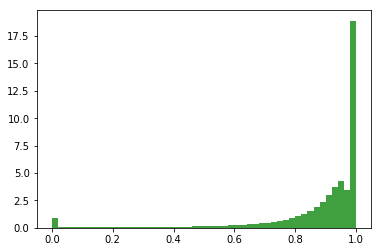

In [8]:
# most of the similarities lie close to zero
sims = np.asarray([float(x[2]) for x in pairs])
print(sims)
#n, bins, patches = plt.hist(sims, 50, normed=1, facecolor='green', alpha=0.75)
n, bins, patches = P.hist(sims, 50, normed=1, histtype='stepfilled')
P.setp(patches, 'facecolor', 'g', 'alpha', 0.75)

P.show()

# 0 means absolutely the same, 1.0 means absolutely dissimilar

In [9]:
zeros = 0
ones = 0
for x in sims:
    if x < 1e-2:
        zeros += 1
    elif x > 1 - 1e-2:
        ones += 1
print("zeros:", zeros)
print("ones:", ones)

zeros: 5648
ones: 114098


In [10]:
msd_to_info['TRNUDQL128E0783E5C']

('SHSDataset/mp3/3344 - Bali_Ha_i/18044.clip.mp3',
 "Bali Ha'i",
 'SODXUGX12A6310DBED',
 'On The Moon',
 'ARITVH41187B9A5FE4',
 'e670db87-f910-4286-bfc6-d7ddd0b0bfbd',
 'Peter Cincotti',
 239.25506,
 0.750112125537,
 0.433159162811,
 2004,
 18044,
 59758,
 28094,
 (('easy listening', 50.0), ('00s', 25.0), ('jazz', 100.0)))

In [11]:
# test the music tagger model for sanity
if test == True:
    model = MusicTaggerCRNN(weights='msd')

    shuffled_valids = list(valids)
    random.shuffle(shuffled_valids)

    count = 0
    for song in shuffled_valids:    
        audio_path = '/mnt/kahuna/MSD_audio/' + msd_to_info[song][0]
        tags = msd_to_info[song][-1]
        if type(tags) == type(0) or len(tags) == 0:
            # no tags
            tags = None
            continue
        melgram = preprocess_input(audio_path)
        melgrams = np.expand_dims(melgram, axis=0)

        preds = model.predict(melgrams)
        print(msd_to_info[song][1], msd_to_info[song][3], msd_to_info[song][6])
        print('Predicted:')
        print(decode_predictions(preds))
        print('Actual:')
        if tags is not None:
            print(sorted(list(tags),key=lambda x: x[1],reverse=True))
        else:
            print("N/A")
        print('-'*20)
        count += 1
        if count >= 20:
            break

In [12]:
pairs = np.asarray(pairs)
indices = np.arange(pairs.shape[0], dtype="int32")
np.random.shuffle(indices)
pairs = pairs[indices]
split_pt = int(len(pairs)/7)
pairs_train = pairs[:split_pt]
pairs_test = pairs[split_pt:]

In [13]:
# some useful functions:
def euc_dist(x):
    'Merge function: euclidean_distance(u,v)'
    print(x[0].get_shape(), x[1].get_shape())
    diff = tf.subtract(x[0], x[1])
    diff_sq = tf.square(diff)
    #output = tf.reduce_sum(diff_sq, 2)
    output_sq = tf.reduce_sum(diff_sq, 1)
    output = tf.sqrt(output_sq)
    output = tf.reshape(output, (-1,1))
    print("output.get_shape()", output.get_shape())
    return output

def euc_dist_shape(input_shape):
    'Merge output shape'
    shape = list(input_shape)
    #outshape = (shape[0][0],shape[0][1])
    outshape = (shape[0][0],1)
    print("outshape", outshape)
    return tuple(outshape)

def euc(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    dist = y_pred
    return K.mean(y_true * K.square(dist) + (1 - y_true) * K.square(K.maximum(params['glob_margin'] - dist, 0)))

def custom_crossentropy(y_true, y_pred):
    dist = y_pred
    return K.mean(y_true * K.log(K.tanh(K.square(dist))) + (1 - y_true) * K.log(1 - K.tanh(K.square(dist))))

def siamese_accuracy(y_true, y_pred):
    margin = tf.constant([params['glob_margin']])
    zero = tf.constant([0.0])
    return K.mean(K.equal(np.abs(1 - y_true), K.cast(K.greater_equal(y_pred, margin), 'float32')))

# add callback for learning rate
def step_decay(epoch):
    initial_lrate = 1e-10
    drop = 0.1
    epochs_drop = 150.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)

csv_logger = CSVLogger(run_name + '.log')
checkpointer = ModelCheckpoint(filepath='./' + run_name + '.hdf5', verbose=1, save_best_only=True)
optimizer = rmsprop(lr=0.0)

In [14]:
# now build actual model

# Determine proper input shape
if K.image_dim_ordering() == 'th':
    input_shape = (1, 96, 1366)
else:
    input_shape = (96, 1366, 1)

melgram_input1 = Input(shape=input_shape)
melgram_input2 = Input(shape=input_shape)

# Determine input axis
if K.image_dim_ordering() == 'th':
    channel_axis = 1
    freq_axis = 2
    time_axis = 3
else:
    channel_axis = 3
    freq_axis = 1
    time_axis = 2

layers = []
# Input block
layers.append(ZeroPadding2D(padding=(0, 37)))
layers.append(BatchNormalization(axis=time_axis, name='bn_0_freq'))

# Conv block 1
layers.append(Convolution2D(64, 3, 3, border_mode='same', name='conv1')) 
layers.append(BatchNormalization(axis=channel_axis, mode=0, name='bn1')) 
layers.append(ELU()) 
layers.append(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool1')) 

# Conv block 2
layers.append(Convolution2D(128, 3, 3, border_mode='same', name='conv2')) 
layers.append(BatchNormalization(axis=channel_axis, mode=0, name='bn2')) 
layers.append(ELU()) 
layers.append(MaxPooling2D(pool_size=(3, 3), strides=(3, 3), name='pool2')) 

# Conv block 3
layers.append(Convolution2D(128, 3, 3, border_mode='same', name='conv3')) 
layers.append(BatchNormalization(axis=channel_axis, mode=0, name='bn3')) 
layers.append(ELU()) 
layers.append(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), name='pool3')) 

# Conv block 4
layers.append(Convolution2D(128, 3, 3, border_mode='same', name='conv4'))
layers.append(BatchNormalization(axis=channel_axis, mode=0, name='bn4'))
layers.append(ELU())
layers.append(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), name='pool4'))

# reshaping
layers.append(Reshape((15, 128)))

# GRU block 1, 2, output
layers.append(GRU(32, return_sequences=True, name='gru1'))
layers.append(GRU(32, return_sequences=False, name='gru2'))

x1 = melgram_input1
x2 = melgram_input2

for l in layers:
    x1 = l(x1)
    x2 = l(x2)

output = merge([x1, x2], mode=euc, output_shape=euc_dist_shape)

model = Model(input=[melgram_input1, melgram_input2], output=[output])

# Load weights
if K.image_dim_ordering() == 'tf':
    weights_path = get_file('music_tagger_crnn_weights_tf_kernels_tf_dim_ordering.h5',
                            TF_WEIGHTS_PATH,
                            cache_subdir='models')
else:
    weights_path = get_file('music_tagger_crnn_weights_tf_kernels_th_dim_ordering.h5',
                            TH_WEIGHTS_PATH,
                            cache_subdir='models')
model.load_weights(weights_path, by_name=True)
if K.backend() == 'theano':
    convert_all_kernels_in_model(model)

#model.compile(optimizer=optimizer, loss=contrastive_loss, metrics=['mean_squared_error'])
model.compile(optimizer=optimizer, loss=custom_crossentropy, metrics=['mean_squared_error'])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", name="conv1")`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(name="bn1", axis=3)`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", name="conv2")`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:35: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(name="bn2", axis=3)`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", name="conv3")`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:41: UserWarning: Update your `BatchNormalization` call to 

outshape (None, 1)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:65: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python3.5/dist-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:67: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


In [15]:
weights = model.trainable_weights # weight tensors

#print([weight.name[:-2] for weight in weights])
#print([(weight.name[:-2],model.get_layer(weight.name[:-2])) for weight in weights])

#for weight in weights:
#    print(weight.name[:weight.name.rfind('/')])
#    print(model.get_layer(weight.name[:weight.name.rfind('/')]).trainable)
#weights = [weight for weight in weights if model.get_layer(weight.name[:weight.name.rfind('/')]).trainable] # filter down weights tensors to only ones which are trainable
gradients = model.optimizer.get_gradients(model.total_loss, weights) # gradient tensors

print(weights)
print(gradients)
# ==> [dense_1_W, dense_1_b]

[<tensorflow.python.ops.variables.Variable object at 0x7ff6ca5124e0>, <tensorflow.python.ops.variables.Variable object at 0x7ff6ca5128d0>, <tensorflow.python.ops.variables.Variable object at 0x7ff6d3baef98>, <tensorflow.python.ops.variables.Variable object at 0x7ff6cf62ed30>, <tensorflow.python.ops.variables.Variable object at 0x7ff6d18f50b8>, <tensorflow.python.ops.variables.Variable object at 0x7ff6d18f5668>, <tensorflow.python.ops.variables.Variable object at 0x7ff6d3925be0>, <tensorflow.python.ops.variables.Variable object at 0x7ff6d3925cc0>, <tensorflow.python.ops.variables.Variable object at 0x7ff6d38c2c50>, <tensorflow.python.ops.variables.Variable object at 0x7ff6d38c26a0>, <tensorflow.python.ops.variables.Variable object at 0x7ff6d386ffd0>, <tensorflow.python.ops.variables.Variable object at 0x7ff6d3800828>, <tensorflow.python.ops.variables.Variable object at 0x7ff6d380dd68>, <tensorflow.python.ops.variables.Variable object at 0x7ff6d3818470>, <tensorflow.python.ops.variables.

In [16]:
K.learning_phase()

<tf.Tensor 'keras_learning_phase:0' shape=<unknown> dtype=bool>

In [17]:
input_tensors = [model.inputs[0], # input data
                 model.inputs[1],
                 model.sample_weights[0], # how much to weight each sample by
                 model.targets[0], # labels
                 K.learning_phase() # train or test mode
                 #"HELLO"
]

get_gradients = K.function(inputs=input_tensors, outputs=gradients)

In [18]:
crnn_out1_f = K.function(model.inputs, [x1])
crnn_out2_f = K.function(model.inputs, [x2])
crnn1_grad_f = K.function(model.inputs, [K.gradients(x1, model.inputs)[0]])
crnn2_grad_f = K.function(model.inputs, [K.gradients(x2, model.inputs)[1]])
end_grad_f = K.function([x1,x2], K.gradients(output, [x1,x2]))

In [19]:
model.layers

In [20]:
def librosa_exists():
    try:
        __import__('librosa')
    except ImportError:
        return False
    else:
        return True
    
def preprocess_input(audio_path, dim_ordering='default'):
    '''Reads an audio file and outputs a Mel-spectrogram.
    '''
    if dim_ordering == 'default':
        dim_ordering = K.image_dim_ordering()
    assert dim_ordering in {'tf', 'th'}

    if librosa_exists():
        import librosa
    else:
        raise RuntimeError('Librosa is required to process audio files.\n' +
                           'Install it via `pip install librosa` \nor visit ' +
                           'http://librosa.github.io/librosa/ for details.')

    # mel-spectrogram parameters
    SR = 12000
    N_FFT = 512
    N_MELS = 96
    HOP_LEN = 256
    DURA = 29.12
    
    try:
        src, sr = librosa.load(audio_path, sr=SR)
    except:
        print("Unexpected error5:", sys.exc_info()[0])
        raise
    n_sample = src.shape[0]
    n_sample_wanted = int(DURA * SR)

    # trim the signal at the center
    if n_sample < n_sample_wanted:  # if too short
        src = np.hstack((src, np.zeros((int(DURA * SR) - n_sample,))))
    elif n_sample > n_sample_wanted:  # if too long
        src = src[int((n_sample - n_sample_wanted) / 2):
                  int((n_sample + n_sample_wanted) / 2)]

    logam = librosa.logamplitude
    melgram = librosa.feature.melspectrogram
    x = logam(melgram(y=src, sr=SR, hop_length=HOP_LEN,
                      n_fft=N_FFT, n_mels=N_MELS) ** 2,
                      ref_power=1.0)
    #librosa.display.specshow(x, sr=SR, hop_length=HOP_LEN,
    #                  n_fft=N_FFT, n_mels=N_MELS)

    if dim_ordering == 'th':
        x = np.expand_dims(x, axis=0)
    elif dim_ordering == 'tf':
        x = np.expand_dims(x, axis=3)
    return x

In [21]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import librosa

def getMfcc(audio_path):
    SR = 12000
    SR = 12000
    N_FFT = 512
    N_MELS = 96
    HOP_LEN = 256
    DURA = 29.12
    #(rate,sig) = wav.read("AudioFile.wav")
    src, sr = librosa.load(audio_path, sr=SR)
    n_sample = src.shape[0]
    n_sample_wanted = int(DURA * SR)

    # trim the signal at the center
    if n_sample < n_sample_wanted:  # if too short
        src = np.hstack((src, np.zeros((int(DURA * SR) - n_sample,))))
    elif n_sample > n_sample_wanted:  # if too long
        src = src[int((n_sample - n_sample_wanted) / 2):
                  int((n_sample + n_sample_wanted) / 2)]
    #mfcc_feat = mfcc(sig,rate)
    mfcc_feat = mfcc(src,samplerate=sr,)

    print(mfcc_feat)
    plt.plot(mfcc_feat)
    plt.show()
    return mfcc_feat

In [22]:
"""
def generate_samples(pairs, minibatch_size):
    i = 0
    n = len(pairs)
    while 1:
        x_1_arr = np.empty((minibatch_size, 96, 1366, 1))
        x_2_arr = np.empty((minibatch_size, 96, 1366, 1))
        y_arr = np.empty((minibatch_size,))
        while i < minibatch_size:
            rand_num = random.randint(0,n-1)
            print(rand_num)
            x_1, x_2, y = pairs[rand_num]
            audio_path1 = '/mnt/kahuna/MSD_audio/' + msd_to_info[x_1][0]
            audio_path2 = '/mnt/kahuna/MSD_audio/' + msd_to_info[x_2][0]
            #getMfcc(audio_path1)
            try:
                melgram1 = preprocess_input(audio_path1)
                melgram2 = preprocess_input(audio_path2)
            except:
                print("Unexpected error4:", sys.exc_info()[0])
                #print(audio_path1, audio_path2)
                #continue
                raise
            if np.sum(np.isnan(melgram1)) > 0 or np.sum(np.isnan(melgram2)) > 0:
                print("nan!")
                continue
            if np.sum(melgram1) > 0 or np.sum(melgram2) > 0:
                print("zero!")
                continue
            x_1_arr[i,:,:,:] = np.expand_dims(melgram1, axis=0)
            x_2_arr[i,:,:,:] = np.expand_dims(melgram2, axis=0)
            y_arr[i] = y
            i += 1
        #print("generated the {}th sample".format(i))
        yield(([x_1_arr, x_2_arr], y_arr))
"""

'\ndef generate_samples(pairs, minibatch_size):\n    i = 0\n    n = len(pairs)\n    while 1:\n        x_1_arr = np.empty((minibatch_size, 96, 1366, 1))\n        x_2_arr = np.empty((minibatch_size, 96, 1366, 1))\n        y_arr = np.empty((minibatch_size,))\n        while i < minibatch_size:\n            rand_num = random.randint(0,n-1)\n            print(rand_num)\n            x_1, x_2, y = pairs[rand_num]\n            audio_path1 = \'/mnt/kahuna/MSD_audio/\' + msd_to_info[x_1][0]\n            audio_path2 = \'/mnt/kahuna/MSD_audio/\' + msd_to_info[x_2][0]\n            #getMfcc(audio_path1)\n            try:\n                melgram1 = preprocess_input(audio_path1)\n                melgram2 = preprocess_input(audio_path2)\n            except:\n                print("Unexpected error4:", sys.exc_info()[0])\n                #print(audio_path1, audio_path2)\n                #continue\n                raise\n            if np.sum(np.isnan(melgram1)) > 0 or np.sum(np.isnan(melgram2)) > 0:\n  

In [23]:
def generate_samples(pairs, minibatch_size):
    n = len(pairs)
    tot = np.product((96,1366,1))
    tot_count = 0
    while 1:
        x_1_arr = np.empty((minibatch_size, 96, 1366, 1))
        x_2_arr = np.empty((minibatch_size, 96, 1366, 1))
        y_arr = np.empty((minibatch_size,))
        i = 0
        while i < minibatch_size:
            rand_num = random.randint(0,n-1)
            #print(rand_num)
            x_1, x_2, y = pairs[rand_num]
            audio_path1 = '/mnt/kahuna/MSD_audio/' + msd_to_info[x_1][0]
            audio_path2 = '/mnt/kahuna/MSD_audio/' + msd_to_info[x_2][0]
            #getMfcc(audio_path1)
            try:
                melgram1 = preprocess_input(audio_path1)
                melgram2 = preprocess_input(audio_path2)
            except:
                print("Unexpected error4:", sys.exc_info()[0])
                #print(audio_path1, audio_path2)
                continue
                #raise
            print("tot_count:", tot_count, np.sum(np.isclose(melgram1, melgram2))/tot)
            if np.sum(np.isclose(melgram1, melgram2))/tot > 0.5:
                print("too close!")
                continue
            if np.sum(np.isnan(melgram1)) > 0 or np.sum(np.isnan(melgram2)) > 0:
                print("nan!")
                continue
            if np.sum(melgram1) > 0 or np.sum(melgram2) > 0:
                print("zero!")
                continue
            x_1_arr[i,:,:,:] = np.expand_dims(melgram1, axis=0)
            x_2_arr[i,:,:,:] = np.expand_dims(melgram2, axis=0)
            y_arr[i] = y
            #y_arr[i] = tot_count
            i += 1
            tot_count += 1
        #print(y_arr)
        #print("generated the {}th sample".format(i))
        for x1,x2 in zip(x_1_arr, x_2_arr):
            assert not (np.sum(np.isclose(x1, x2))/tot > 0.5)
        yield(([x_1_arr, x_2_arr], y_arr))
        #yield(([0, 0], 0))

count = 0
tf_false = tf.cast(tf.constant([0.0]), 'bool')
"""
for x, y in generate_samples(pairs_train, 1):
    x_1, x_2 = x
    # most of the similarities lie close to zero
    vals = x[0].flatten()
    #n, bins, patches = plt.hist(sims, 50, normed=1, facecolor='green', alpha=0.75)
    n, bins, patches = P.hist(vals, 50, normed=1, histtype='stepfilled')
    P.setp(patches, 'facecolor', 'g', 'alpha', 0.75)

    P.show()
    #print(x_1,x_2)
    #K.set_learning_phase(False)
    print(crnn_out1_f([x_1,x_2]))
    print(crnn_out2_f([x_1,x_2]))
    dist = model.predict([x_1, x_2])
    print(model.predict([x_1, x_2]))
    loss = contrastive_loss(y, dist)
    loss = K.eval(loss)
    print(loss)
    #print(lstm_out1_f([x_1,x_2]), lstm_out2_f([x_1,x_2]))
    count += 1
    if count > 0:
        break
"""

"\nfor x, y in generate_samples(pairs_train, 1):\n    x_1, x_2 = x\n    # most of the similarities lie close to zero\n    vals = x[0].flatten()\n    #n, bins, patches = plt.hist(sims, 50, normed=1, facecolor='green', alpha=0.75)\n    n, bins, patches = P.hist(vals, 50, normed=1, histtype='stepfilled')\n    P.setp(patches, 'facecolor', 'g', 'alpha', 0.75)\n\n    P.show()\n    #print(x_1,x_2)\n    #K.set_learning_phase(False)\n    print(crnn_out1_f([x_1,x_2]))\n    print(crnn_out2_f([x_1,x_2]))\n    dist = model.predict([x_1, x_2])\n    print(model.predict([x_1, x_2]))\n    loss = contrastive_loss(y, dist)\n    loss = K.eval(loss)\n    print(loss)\n    #print(lstm_out1_f([x_1,x_2]), lstm_out2_f([x_1,x_2]))\n    count += 1\n    if count > 0:\n        break\n"

[[ -2.37843016  -8.07968859 -13.54347174 ...,  -8.05539889  -0.9564719
   -2.28410053]
 [ -2.45591515  -7.41843846 -13.60669785 ...,  -4.00184937  -1.40267418
   -3.8395127 ]
 [ -2.31388113  -5.75595294 -16.38217427 ...,  -0.04773316  -0.8857626
   -0.77255285]
 ..., 
 [ -1.84804944 -12.4303273   -6.41227014 ..., -11.28913757  -1.76969401
    1.84003965]
 [ -1.31799006 -10.44794187  -4.9589534  ...,  -8.43637212   3.6664526
   -3.59601978]
 [ -1.49486225  -9.61656855  -1.43415403 ..., -11.41430778   2.0306632
   -5.03996482]]


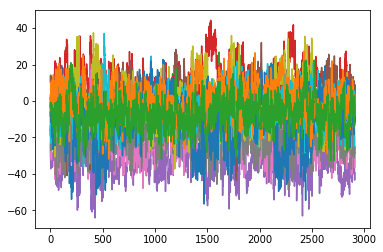

[[ -1.30216009 -12.24488686  14.77067641 ...,  -5.50918163 -10.84094466
  -16.30582167]
 [ -1.42736423 -11.40970686  18.83977442 ..., -12.97191652  -9.01658448
  -25.21088562]
 [ -1.29454248 -14.86726579  19.57612976 ...,  -8.20046553  -2.71727721
  -18.57050541]
 ..., 
 [ -3.40885933   4.71215513  -7.64489783 ..., -21.97130768  -7.31726154
   24.00452269]
 [ -3.53920319   5.56328318  -6.92734106 ..., -20.02668413  -2.1056872
   23.06755337]
 [ -3.80774642   4.44953896  -6.81770147 ..., -24.76050643  -4.82233099
   18.07084267]]


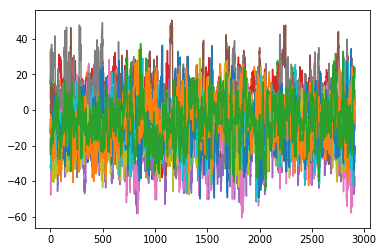

In [24]:
rand_num = random.randint(0,len(pairs)-1)
x_1, x_2, y = pairs[rand_num]
audio_path1 = '/mnt/kahuna/MSD_audio/' + msd_to_info[x_1][0]
audio_path2 = '/mnt/kahuna/MSD_audio/' + msd_to_info[x_2][0]
m11 = getMfcc(audio_path1)
m12 = getMfcc(audio_path2)
m21 = preprocess_input(audio_path1)
m22 = preprocess_input(audio_path2)

In [25]:
m11.shape

(2911, 13)

In [26]:
dir(model.layers[-3])

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_inbound_node',
 '_built',
 '_constraints',
 '_get_node_attribute_at_index',
 '_initial_weights',
 '_losses',
 '_non_trainable_weights',
 '_per_input_losses',
 '_per_input_updates',
 '_trainable_weights',
 '_updates',
 'activation',
 'activity_regularizer',
 'add_loss',
 'add_update',
 'add_weight',
 'assert_input_compatibility',
 'bias',
 'bias_constraint',
 'bias_h',
 'bias_initializer',
 'bias_r',
 'bias_regularizer',
 'bias_z',
 'build',
 'built',
 'call',
 'compute_mask',
 'compute_output_shape',
 'constraints',
 'count_params',
 'dropout',
 'from_config',
 'get_config',
 'get_constants',
 'get_initial_states',
 'get_inp

In [27]:
model.layers[-2].get_weights()

[array([[-0.03883676, -0.19665682,  0.09519399, ..., -0.01679893,
         -0.11232486, -0.05320075],
        [ 0.10318386,  0.00750141,  0.0877763 , ...,  0.28539926,
         -0.26765713,  0.12707934],
        [ 0.02139056, -0.20284753, -0.13729262, ...,  0.06997423,
         -0.18604344,  0.16012473],
        ..., 
        [-0.29321396,  0.13158584,  0.07120441, ..., -0.27863073,
          0.13259968, -0.3381097 ],
        [-0.29643059, -0.43796661, -0.38792628, ...,  0.24001566,
          0.53937805, -0.31751484],
        [-0.15014616,  0.38404396,  0.02415507, ...,  0.11745741,
         -0.77597785,  0.13635641]], dtype=float32),
 array([[ -9.47186053e-01,   1.60324425e-01,   1.57704294e-01, ...,
           8.05203021e-02,  -1.34790933e+00,   9.51107025e-01],
        [ -1.63089693e-01,  -6.83150172e-01,  -1.21464767e-01, ...,
           1.34107387e+00,   1.12605959e-01,  -1.98369956e+00],
        [ -2.48719994e-02,  -5.93665354e-02,   9.10036623e-01, ...,
          -9.65682745e-01

In [28]:
# TODO: print all the different learning phases
#print(type(x_1))
#print(model.inputs)
#print(crnn_out1_f([x_2, x_2]))
#print(crnn_out2_f([x_1,x_2]))

In [29]:
"""
import librosa
SR = 12000
for i, p in enumerate(pairs_train):
    x1, x2, y = p
    audio_path1 = '/mnt/kahuna/MSD_audio/' + msd_to_info[x1][0]
    audio_path2 = '/mnt/kahuna/MSD_audio/' + msd_to_info[x2][0]
    src1 = librosa.load(audio_path1, sr=SR)
    src2 = librosa.load(audio_path1, sr=SR)
    print(np.sum(src1), "|", np.sum(src2))
    if i >= 10:
        break
"""

'\nimport librosa\nSR = 12000\nfor i, p in enumerate(pairs_train):\n    x1, x2, y = p\n    audio_path1 = \'/mnt/kahuna/MSD_audio/\' + msd_to_info[x1][0]\n    audio_path2 = \'/mnt/kahuna/MSD_audio/\' + msd_to_info[x2][0]\n    src1 = librosa.load(audio_path1, sr=SR)\n    src2 = librosa.load(audio_path1, sr=SR)\n    print(np.sum(src1), "|", np.sum(src2))\n    if i >= 10:\n        break\n'

In [30]:
"""
# most of the similarities lie close to zero
vals = x[0].flatten()
#n, bins, patches = plt.hist(sims, 50, normed=1, facecolor='green', alpha=0.75)
n, bins, patches = P.hist(vals, 50, normed=1, histtype='stepfilled')
P.setp(patches, 'facecolor', 'g', 'alpha', 0.75)

P.show()
"""

"\n# most of the similarities lie close to zero\nvals = x[0].flatten()\n#n, bins, patches = plt.hist(sims, 50, normed=1, facecolor='green', alpha=0.75)\nn, bins, patches = P.hist(vals, 50, normed=1, histtype='stepfilled')\nP.setp(patches, 'facecolor', 'g', 'alpha', 0.75)\n\nP.show()\n"

In [31]:
with tf.Session() as sess:
    a = tf.get_default_graph().get_tensor_by_name("keras_learning_phase:0")
    print(a)

Tensor("keras_learning_phase:0", dtype=bool)


In [32]:
# debug nans
keep_looping = True
count = 0
for x, y in generate_samples(pairs_train, 1):
    print("close:", [np.sum(np.isclose(x1,x2))/np.product(x1.shape) for x1,x2 in zip(x[0], x[1])])
    prev_input = [x,y]
    prev_weights2 = model.layers[-2].get_weights()
    prev_weights3 = model.layers[-3].get_weights()
    model.fit(x, y, batch_size=1, epochs=1, verbose=1)
    #print("loop num:", count, x)
    for w in model.layers[-2].get_weights():
        if np.sum(np.isnan(w)) > 0:
            keep_looping = False
            break
    if keep_looping == False:
        break
    for w in model.layers[-3].get_weights():
        if np.sum(np.isnan(w)) > 0:
            keep_looping = False
            break
    if keep_looping == False:
        break
    count += 1

tot_count: 0 7.62567105905e-06
close: [7.6256710590531969e-06]
Epoch 1/1


InvalidArgumentError: You must feed a value for placeholder tensor 'keras_learning_phase' with dtype bool
	 [[Node: keras_learning_phase = Placeholder[dtype=DT_BOOL, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'keras_learning_phase', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2827, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-0ddc4c46da91>", line 1, in <module>
    K.learning_phase()
  File "/usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py", line 106, in learning_phase
    name='keras_learning_phase')
  File "/home/henry/.local/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1502, in placeholder
    name=name)
  File "/home/henry/.local/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2149, in _placeholder
    name=name)
  File "/home/henry/.local/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/henry/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/henry/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'keras_learning_phase' with dtype bool
	 [[Node: keras_learning_phase = Placeholder[dtype=DT_BOOL, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [ ]:
for w in model.layers[-2].get_weights():
    if np.sum(np.isnan(w)) > 0:
        print("isnan")
        break
else:
    for x, y in generate_samples(pairs_test, 32):
        break
    ret11 = model.evaluate(x, y, batch_size=32, verbose=1, sample_weight=None)
    ret12 = model.predict(x)
    for x, y in generate_samples(pairs_train, 32):
        break
    ret21 = model.evaluate(x, y, batch_size=32, verbose=1, sample_weight=None)
    ret22 = model.predict(x)
    ret12

In [ ]:
x,y = prev_input
print(y)
print(np.product(x[0].shape))
[np.sum(np.isclose(x1,x2))/np.product(x1.shape) for x1,x2 in zip(x[0], x[1])]

In [ ]:
print(np.std(x[0]))
print(np.std(x[1]))

In [ ]:
print(x[0])
print(x[1])

In [ ]:
model.layers[-2].get_weights()

In [ ]:
model.layers[-3].get_weights()

In [ ]:
x, y = prev_input
print(np.argwhere(np.isnan(x[0])))
print(np.sum(np.isnan(x[0])))
print(np.sum(np.isnan(x[1])))

In [ ]:
len(np.argwhere(np.isnan(x[0])))

In [ ]:
print("test 1")
for elem in x:
    if np.sum(elem) > 0:
        print(np.sum(elem))

print("test 2")
for i in range(x[0].shape[0]):
    if np.sum(np.isclose(x[0][i,...], x[1][i,...])):
        print(i)

In [ ]:
from keras.backend import tensorflow_backend
print(tensorflow_backend._GRAPH_LEARNING_PHASES)
#global _GRAPH_LEARNING_PHASES
tensorflow_backend._GRAPH_LEARNING_PHASES[tf.get_default_graph()] = True
tensorflow_backend._GRAPH_LEARNING_PHASES[tf.get_default_graph()]

In [ ]:
model.layers[0].inbound_nodes[0].output_tensors

In [ ]:
#with tf.Session() as sess:
with sess.as_default():
    a = tf.get_default_graph().get_tensor_by_name("keras_learning_phase:0")
    print(a.eval())

In [ ]:
prev_learning_phase = K.learning_phase()
K.set_learning_phase(False)
x, y = prev_input
model.layers[-2].set_weights(prev_weights2)
model.layers[-3].set_weights(prev_weights3)
dist = model.predict(x)
crnn_out1 = crnn_out1_f(x)
crnn_out2 = crnn_out2_f(x)
loss = contrastive_loss(y, dist)
inputs = [x[0][0,:].reshape(1,96,1366,1),
          x[1][0,:].reshape(1,96,1366,1), # X
          [1], # sample weights
          #y[0].reshape(-1,1), # y
          np.asarray([[1]]).reshape(-1,1),
          0 # learning phase in TEST mode
]
gradients1 = get_gradients(inputs)
for w,g in zip(weights, gradients1):
    print('-'*20)
    w_e = K.eval(w)
    print(w_e)
    print(np.sum(np.isnan(w_e)))
    print('-'*10)
    print(g)
    print(np.sum(np.isnan(g)))
print('-'*20)
print(crnn_out1[0].shape, crnn_out2[0].shape)
print(crnn_out1)
print(crnn_out2)
print("-"*20)
print(end_grad[0].shape, end_grad[1].shape)
print(end_grad)
print(dist)
print(K.eval(loss))

In [ ]:
end_grad[0].shape

In [ ]:
model.fit(x, y)

In [ ]:
print_every = 1 # print every n minibatches
minibatch_size = 8
number_of_batches = 100
hist = model.fit_generator(generate_samples(pairs_train, minibatch_size), steps_per_epoch=print_every, epochs=number_of_batches,
                   #validation_data=generate_samples(pairs_test, minibatch_size), validation_steps=1,
                   callbacks=[lrate, csv_logger, checkpointer], verbose=1)

In [ ]:
X_t = K.placeholder(ndim=2) #specify the right placeholder
Y_t = K.sum(K.square(X_t)) # loss function
fn = K.function([X_t], K.gradients(Y_t, [X_t])) #function to call the gradient

In [ ]:
x_t = np.asarray([[1,2],[3,4]])
fn([x_t])